In [39]:
import sys
sys.path.append("..")

In [40]:
# for auto-reload
%load_ext autoreload
%aimport predictions.etl
%aimport predictions.evaluate
%aimport predictions.predict
%aimport retrieval.data_retriever
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from predictions.etl import ETL
from predictions.evaluate import Evaluate
from predictions.predict import Predict

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [42]:
import random
import numpy as np
import tensorflow as tf
import os

def enable_deterministic_mode():
    SEED = 42

    np.random.seed(SEED)
    random.seed(SEED)
    tf.random.set_seed(SEED)

    tf.keras.backend.clear_session()  # For easy reset of notebook state
    tf.keras.utils.set_random_seed(SEED)
    
    os.environ['PYTHONHASHSEED'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
enable_deterministic_mode()

In [43]:
def build_model(intput_shape):
    model = Sequential()
    
    model.add(LSTM(128, return_sequences=True, input_shape=intput_shape))
    model.add(LSTM(128))
    model.add(Dense(1))
    
    return model

In [44]:
etl = ETL("../../data/bitcoin/price.csv", features=['Price'])
# etl = ETL("../../data/timeseries/coins/bitcoin_chart.csv", features=['Price'])

In [45]:
model = build_model(etl.test_x.shape[1:])
model.compile(optimizer='adam', loss='mean_absolute_error')
model.fit(etl.train_x,
            etl.train_y,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            shuffle=False
        )

Epoch 1/100
11/11 [==============================] - 5s 116ms/step - loss: 0.0420 - val_loss: 0.3193
Epoch 2/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0364 - val_loss: 0.2035
Epoch 3/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0071 - val_loss: 0.0419
Epoch 4/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0182 - val_loss: 0.1372
Epoch 5/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0272 - val_loss: 0.0464
Epoch 6/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0100 - val_loss: 0.0262
Epoch 7/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0144 - val_loss: 0.0788
Epoch 8/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.0935
Epoch 9/100
11/11 [==============================] - 0s 16ms/step - loss: 0.0120 - val_loss: 0.0418
Epoch 10/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0069 - val_loss: 0.023

In [46]:
predict = Predict(model, etl.test_x, etl.test_y)
evaluate = Evaluate(etl.inverse_scale(etl.test_y), etl.inverse_scale(predict.predictions))

4/4 [==============================] - 1s 5ms/step


In [47]:
evaluate.print()

| Metric         |          Value |
|----------------|----------------|
| MSE            |    4.92978e+07 |
| RMSE           | 7021.24        |
| MAE            | 5328.31        |
| R2             |    0.606756    |
| MAPE           |    0.153864    |
| Variance Ratio |    0.90695     |


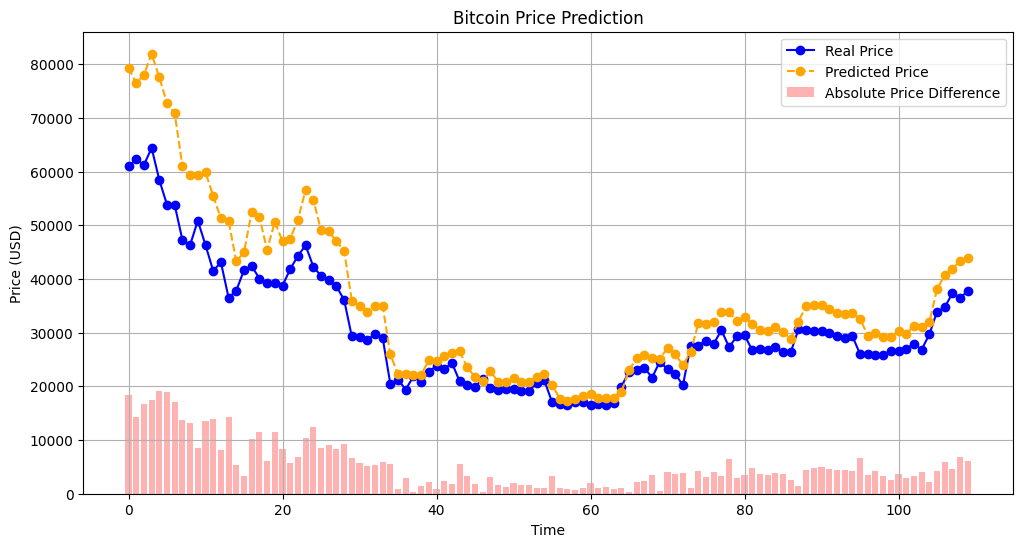

In [48]:
evaluate.plot()

In [56]:
import pandas as pd
df_price = pd.read_csv("../../data/bitcoin/price.csv")
df_original = pd.read_csv("../../data/timeseries/coins/bitcoin_chart.csv")

df_original = df_original[['Price']]
df_price.head()

,Price
0,135.30
1,141.96
2,135.30
3,117.00
4,103.43


In [57]:
df_original.head()

,Price
0,135.30
1,141.96
2,135.30
3,117.00
4,103.43


In [63]:
df = pd.concat([df_original, df_price], axis=1, keys=['Original', 'Price'])

# save df
df.to_csv("../../data/bitcoin/price.csv", index=False)